<a href="https://colab.research.google.com/github/lustea0201/Underdogs/blob/master/Final_project/Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
shape = input("Do you wish to train circle (1) or irregular (2) ? ")
if shape not in ["1","2"]: 
  print("Unknown shape ""%s"". Try again." %shape)
else:
  if shape == "1": 
    shape = "circle"
  else: 
    shape = "irregular" 
  number = input("How many shapes ? Choose from {1,16,32,64} ")
  if number not in ["1","16", "32", "64"]: 
    print("Unknown number ""%s"". Try again." %number)

Do you wish to train circle (1) or irregular (2) ? 2
How many shapes ? Choose from {1,16,32,64} 64


In [84]:
from google.colab import drive
drive.mount('/content/drive/')

import zipfile
data = zipfile.ZipFile("/content/drive/My Drive/Super Resolution/data.zip", 'r')

data.extractall()
data.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# NEED TO RENAME ALL FILES
base_h = "/content/data/" + shape + "_" + number + "/High/Images/"
base_l = "/content/data/" + shape + "_" + number + "/Low/Images/"
if shape == "circle": 
  base_h += "Circle_" + number + "_"
  base_l += "Circle_" + number + "_"
else:
  base_h += "Irregular_" + number + "_"
  base_l += "Irregular_" + number + "_"
for i in range(1,201): 
  src = base_h + str(i) + ".tif"
  drt = "/content/data/" + shape + "_" + number + "/High/Images/" + str(i).zfill(3) + ".tif"
  os.rename(src,drt)
  src = base_l + str(i) + ".tif"
  drt = "/content/data/" + shape + "_" + number + "/Low/Images/" + str(i).zfill(3) + ".tif"
  os.rename(src,drt)

In [74]:
import torch
import torch.nn as nn
import torch.nn.init as init

device = 'cpu'


class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3*upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

model = Net(upscale_factor=2)
model.load_state_dict(torch.load('drive/My Drive/Super Resolution/model_50dB.pth', map_location = torch.device('cpu'))) 


<All keys matched successfully>

In [0]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

X_t = ImageFolder(root = "/content/data/" + shape + "_" + number + "/Low", transform = transforms.ToTensor())
Y_t = ImageFolder(root = "/content/data/" + shape + "_" + number + "/High", transform = transforms.ToTensor())

N_test = 30 
test = []
for i in range(N_test):
  test.append([X_t[i][0], Y_t[i][0]])
test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1)

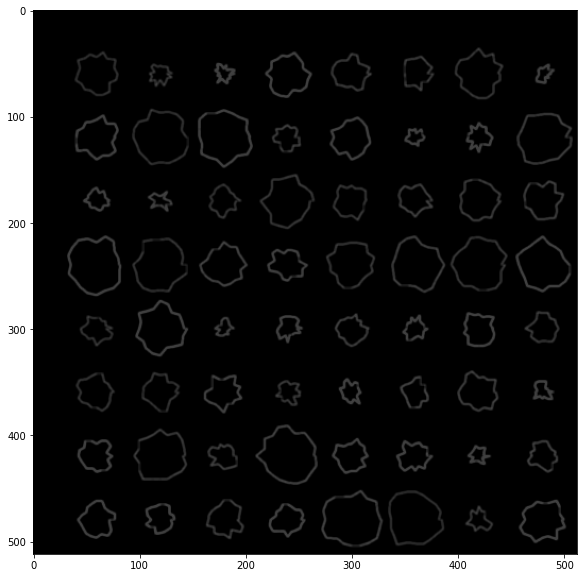

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(X_t[17][0].permute(1,2,0))

In [0]:
from imageio  import imwrite
import numpy as np 
import os 

originals, truths, predictions = [], [], []
i = 1
!rm -rf predictions
os.mkdir("predictions")
with torch.no_grad():
  for batch in test_loader:
    if (i<29):
      input_, target = batch[0].to(device), batch[1].to(device)
      originals.append(input_)
      pred = model(input_)
      predictions.append(pred)
      truths.append(target)
      for p in pred: 
        im = (255*(p.permute(1,2,0).numpy())).astype(np.uint8)
        imwrite("predictions/" + shape + "_" + number + "_%d.tif" %(i), im)
        i += 1

In [78]:
X, Y = next(iter(test_loader))
print(X.shape)

torch.Size([1, 3, 512, 512])


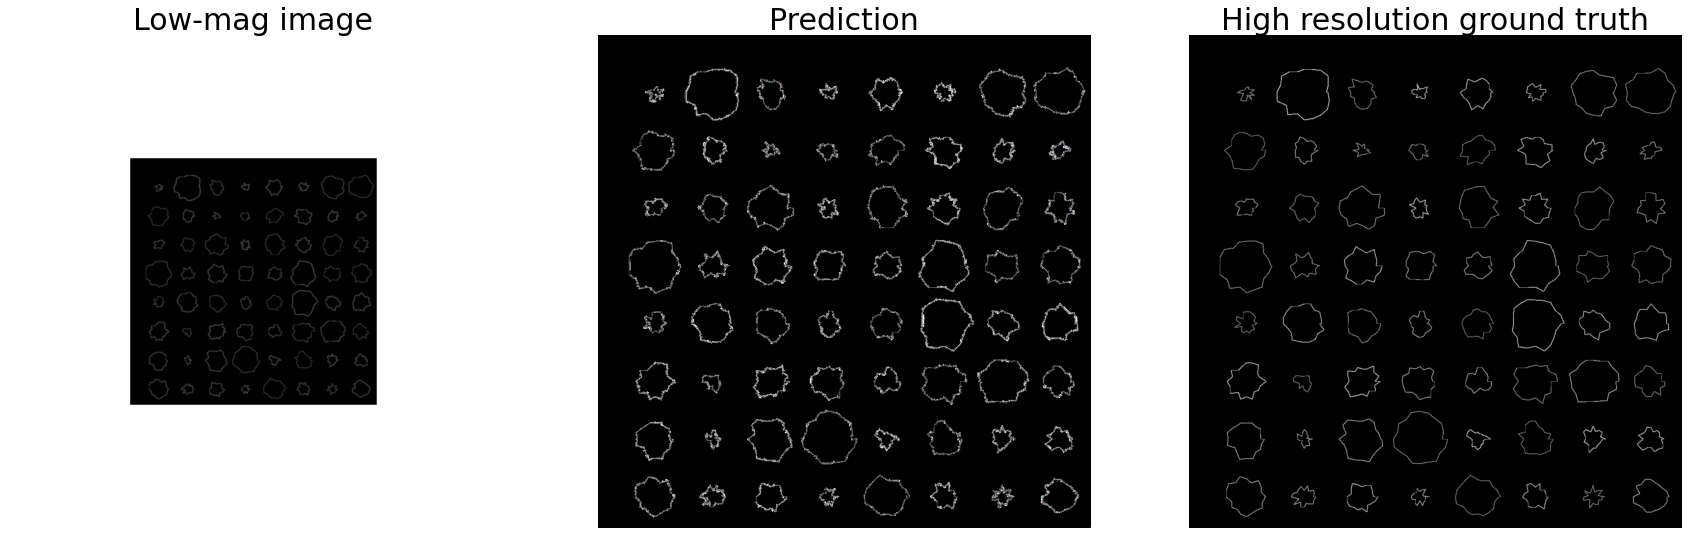

In [79]:
import matplotlib.pyplot as plt 

def compare(o,p,t): 
  fig, axes = plt.subplots(1,3, figsize=(30,15))

  op = torch.ones(t.shape)
  height = t.shape[1]
  width = t.shape[1]
  op[:, height//4:height-height//4, width//4:width-width//4] = o

  op = (255*op.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[0].imshow(op)
  axes[0].set_title("Low-mag image", fontsize=30);
  axes[0].axis('off')
  
  p = (255*p.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[1].imshow(p)
  axes[1].set_title("Prediction", fontsize=30);
  axes[1].axis('off')

  t = (255*t.permute(1, 2, 0)).numpy().astype(np.uint8)
  axes[2].imshow(t)
  axes[2].set_title("High resolution ground truth", fontsize=30);
  axes[2].axis('off')
  
compare(originals[0][0], predictions[0][0], truths[0][0])

In [80]:
download = input("Do you want to download these predictions ? (y or n)")
if (download == "y"):
  !zip -r /content/file.zip /content/predictions
  from google.colab import files
  files.download("/content/file.zip")

Do you want to download these predictions ? (y or n)y
updating: content/predictions/ (stored 0%)
updating: content/predictions/irregular_64_3.tif (deflated 96%)
updating: content/predictions/irregular_64_8.tif (deflated 96%)
updating: content/predictions/irregular_64_1.tif (deflated 96%)
updating: content/predictions/irregular_64_26.tif (deflated 96%)
updating: content/predictions/irregular_64_9.tif (deflated 96%)
updating: content/predictions/irregular_64_24.tif (deflated 96%)
updating: content/predictions/irregular_64_13.tif (deflated 96%)
updating: content/predictions/irregular_64_14.tif (deflated 96%)
updating: content/predictions/irregular_64_5.tif (deflated 96%)
updating: content/predictions/irregular_64_21.tif (deflated 96%)
updating: content/predictions/irregular_64_2.tif (deflated 96%)
updating: content/predictions/irregular_64_11.tif (deflated 96%)
updating: content/predictions/irregular_64_16.tif (deflated 96%)
updating: content/predictions/irregular_64_25.tif (deflated 96%)

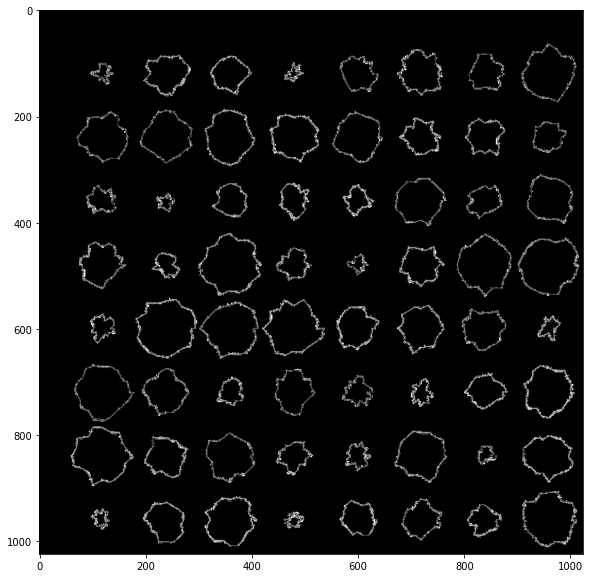

In [81]:
from imageio  import imread
i = 23
img_read = imread("predictions/" + shape + "_" + number + "_%d.tif" %i)
plt.figure(figsize=(10,10))
plt.imshow(img_read)
